#### <strong>第三次作品：三個分類器於兩組影像的評比實驗( AT&T )</strong>
學號：711333104

姓名：林子齊
<hr>

 <font color=skyblue>作品目標</font>：本作品旨在比較不同分類器在原始資料與降維後（主成分資料）下的分類效能差異，並觀察資料型態轉換對模型表現的影響。

透過 Logistic Regression、SVM（含不同 kernel）、以及 MLP 等模型，分別對原始與 PCA 處理後的資料進行訓練與測試，評估各模型在不同情境下的準確率與穩定性。

最終目標為找出在不同資料條件下最具效能與穩定性的分類模型，並提供適用於高維特徵資料的模型選擇建議。
 <hr>

In [4]:
import pandas as pd
import numpy as np
from HW3_common_utils import load_csv_data, split_and_scale, apply_pca, run_logistic_regression_cv, run_logistic_gridcv, \
    run_svm_classification, run_mlp_classifier, plot_mlp_loss_curve, plot_mlp_confusion_matrix

先觀察資料的型態。


In [6]:
data_file = 'Data/face_data.csv'
df = pd.read_csv(data_file)

# 顯示前幾筆資料
print(df.head())

# 顯示欄位名稱與資料型態
print(df.info())

# 若想看欄位名稱
print(df.columns)

# 顯示資料維度
print("資料維度：", df.shape)


          0         1         2         3         4         5         6  \
0  0.309917  0.367769  0.417355  0.442149  0.528926  0.607438  0.657025   
1  0.454545  0.471074  0.512397  0.557851  0.595041  0.640496  0.681818   
2  0.318182  0.400826  0.491736  0.528926  0.586777  0.657025  0.681818   
3  0.198347  0.194215  0.194215  0.194215  0.190083  0.190083  0.243802   
4  0.500000  0.545455  0.582645  0.623967  0.648760  0.690083  0.694215   

          7         8         9  ...      4087      4088      4089      4090  \
0  0.677686  0.690083  0.685950  ...  0.669422  0.652893  0.661157  0.475207   
1  0.702479  0.710744  0.702479  ...  0.157025  0.136364  0.148760  0.152893   
2  0.685950  0.702479  0.698347  ...  0.132231  0.181818  0.136364  0.128099   
3  0.404959  0.483471  0.516529  ...  0.636364  0.657025  0.685950  0.727273   
4  0.714876  0.723140  0.731405  ...  0.161157  0.177686  0.173554  0.177686   

       4091      4092      4093      4094      4095  target  
0  0.1

### 資料切分說明

為了進行交叉驗證時能減少資料偏差，我們將**資料依照原始類別比例**進行切分，將資料集分成：

- **訓練集（Training Set）**：70%
- **測試集（Testing Set）**：30%

透過**分層切分（stratified split）**，確保每一類別在訓練集與測試集中都保有相近的比例，有助於：

- 提高交叉驗證的代表性
- 降低模型偏誤（bias）
- 評估模型在未見資料上的泛化能力

In [7]:
data_file = 'Data/face_data.csv'
X, y = load_csv_data(data_file)
X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(X, y, test_size=0.3)

print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Testing samples: {X_test_scaled.shape[0]}")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Testing data shape: {X_test_scaled.shape}")
print("類別數量：", len(np.unique(y)))

Training samples: 280
Testing samples: 120
Training data shape: (280, 4096)
Testing data shape: (120, 4096)
類別數量： 40


## 1. 原始資料

### 1-1 多元羅吉斯回歸 (Multinomial Logistic Regression)

分別使用 `LogisticRegressionCV` 和 `GridSearchCV` 兩種方法對羅吉斯迴歸進行超參數搜尋與模型評估：

- 以下使用 `LogisticRegressionCV` 執行 5-fold 交叉驗證，設定 20 個對數尺度的 C 值，solver 為 `'lbfgs'`，得到以下結果：

In [ ]:
result = run_logistic_regression_cv(
    X_train_scaled, X_test_scaled, y_train, y_test,
    solver='lbfgs',
    Cs= np.logspace(-5, 5, 20),
    cv=5,
    tol=1e-6,
    max_iter=int(1e6),
    verbose=0,
    print_report=True
)

Logistic Regression with CV (solver = lbfgs)
Best C = [69.51927962 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962
 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962
 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962
 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962
 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962
 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962 69.51927962
 69.51927962 69.51927962 69.51927962 69.51927962]
Training Accuracy: 100.00%
Testing Accuracy : 97.50%
Elapsed time: 222.68 seconds


模型在所有交叉驗證中皆選擇較大的 C 值，顯示資料具良好可分性，模型傾向降低正則化強度。整體而言，訓練與測試準確率皆高、交叉驗證結果穩定，展現優異效能。

- 以下使用 `GridSearchCV` 執行 5-fold 交叉驗證，設定 C 值為 `0.1, 1, 10` ，solver 為 `'lbfgs', 'newton-cg', 'saga'`，得到以下結果：

In [ ]:
param_grid = {
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'C': [0.1, 1, 10]
}

result = run_logistic_gridcv(X_train_scaled, y_train, param_grid=param_grid)

{'C': 10, 'solver': 'newton-cg'}
0.9476190476190476
LogisticRegression(C=10, max_iter=1000000, solver='newton-cg', tol=1e-06)
Elapsed time: 22823.27 seconds


GridSearchCV 共搜尋 9 組參數組合（3 個 solver × 3 個 C），每組皆進行 5-fold 交叉驗證，導致總耗時達 22,823 秒（超過 6 小時），計算成本相當高。雖然耗時較久，但交叉驗證下的平均準確率約為 94.76%，顯示所選參數組合在訓練階段表現良好。

### 1-2 支援向量機
#### 1. 使用線性核（`kernel='linear'`）的 SVC 模型進行分類

In [48]:
result = run_svm_classification(
    X_train_scaled, X_test_scaled, y_train, y_test,
    kernel='linear',
    use_linear_svc=False 
)

SVM Classification (SVC-linear)
Test Accuracy: 96.67%
Elapsed Time: 0.13 seconds


模型在測試集上表現良好，準確率達到 96.67%，顯示線性決策邊界對此資料集具有良好分類能力。

#### 2. 使用線性核（`kernel='rbf'`）的 SVC 模型進行分類

In [20]:
result = run_svm_classification(
    X_train_scaled, X_test_scaled, y_train, y_test,
    kernel='rbf',
    C=0.1,
    gamma=0.2,
    use_linear_svc=False
)


SVM Classification (SVC-rbf)
Test Accuracy: 90.00%
Elapsed Time: 0.13 seconds


手動調整多組 `C` 與 `gamma` 參數後，模型的最佳測試準確率為 **90.00%**，整體表現尚可。

#### 3. 使用線性核（`kernel='poly'`）的 SVC 模型進行分類
- degree=2

In [44]:
result = run_svm_classification(
    X_train_scaled, X_test_scaled, y_train, y_test,
    kernel='poly',
    degree=2,
    gamma='auto',
    use_linear_svc=False 
)

SVM Classification (SVC-poly)
Test Accuracy: 78.33%
Elapsed Time: 0.10 seconds


-  degree=3

In [42]:
result = run_svm_classification(
    X_train_scaled, X_test_scaled, y_train, y_test,
    kernel='poly',
    degree=3,
    gamma='auto',
    use_linear_svc=False 
)

SVM Classification (SVC-poly)
Test Accuracy: 63.33%
Elapsed Time: 0.10 seconds


使用多項式核（`kernel='poly'`）的 SVM 模型在本資料集上的表現不佳，且隨著多項式次數增加，模型效能明顯下降。當 **degree = 2** 時，測試準確率為 **78.33%**，而提高至 **degree = 3** 時，準確率驟降至 **63.33%**，顯示決策邊界可能過於複雜，導致**過擬合**或**泛化能力下降**。整體而言，本資料不適合採用高階多項式核函數進行建模。

#### 4. 使用 `LinearSVC`


In [13]:
result = run_svm_classification(
    X_train_scaled, X_test_scaled, y_train, y_test,
    use_linear_svc=True  
)

SVM Classification (LinearSVC)
Test Accuracy: 98.33%
Elapsed Time: 58.96 seconds


LinearSVC 在測試集上表現優異，測試準確率高達 **98.33%**，為目前所有支援向量機模型中的最佳表現，顯示資料具有**明顯的線性可分性**，適合使用線性分類器進行建模。然而，**訓練時間明顯較長**（近 1 分鐘），相比使用 `SVC(kernel='linear')` 僅需 0.13 秒，測試準確率也達 **96.67%** ，其效率顯著偏低。


### 1-3 神經網路

#### 1. 使用一層隱藏層、100 個神經元的多層感知器（MLP）進行訓練，並採用 ReLU 作為啟用函數，Adam 作為優化器。

MLP Classifier Report
Test Accuracy: 96.67%
Elapsed Time: 3.94 seconds


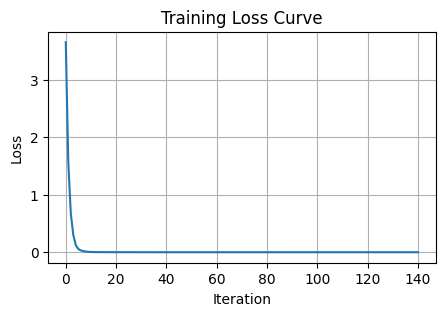

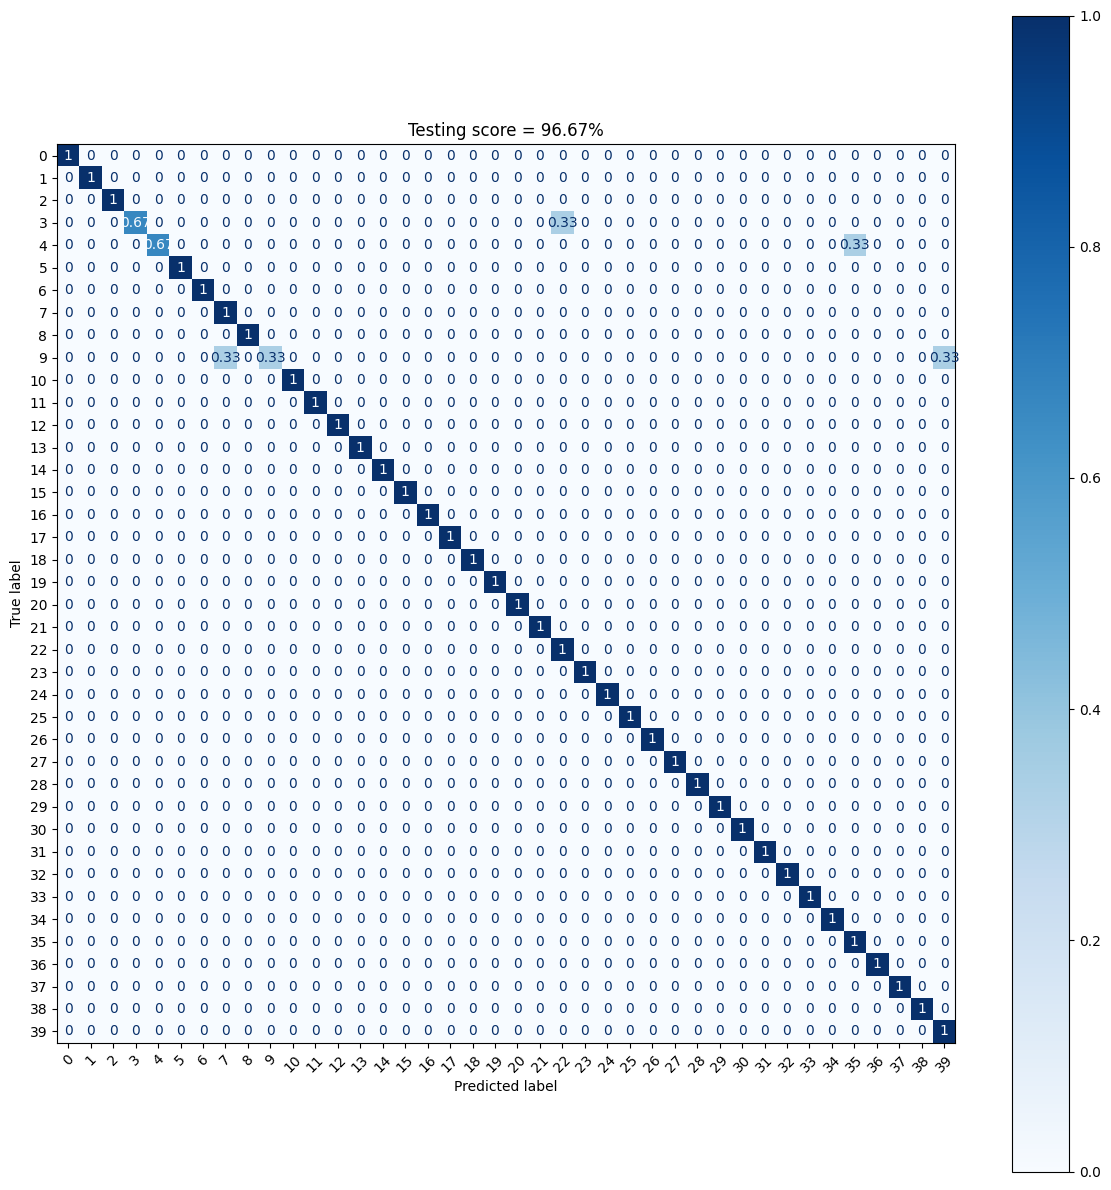

In [8]:
result = run_mlp_classifier(
    X_train_scaled, X_test_scaled, y_train, y_test,
    hidden_layers=(100,),
    activation='relu',
    solver='adam',
    print_report=True,
    random_state=42
)

plot_mlp_loss_curve(result['model'])
plot_mlp_confusion_matrix(result['model'], X_test_scaled, y_test)


**測試準確率（Test Accuracy）**：96.67%，模型分類效果良好。

從損失曲線可觀察到以下現象：

- **快速下降**：訓練初期損失迅速下降，模型快速學習到關鍵特徵。
- **平穩收斂**：約在第 10 次迭代後，損失值趨於穩定並接近 0，顯示模型已成功收斂，未出現震盪或過擬合現象。
- **曲線平滑**：整體曲線平滑穩定，代表訓練過程順利，Adam 優化器在此任務中表現良好。

從混淆矩陣可以觀察到以下現象：

- 多數類別的預測集中於對角線，且對角線上的值幾乎皆為 **1.00**，表示被正確分類的比例高。
- 僅有少數幾筆樣本產生誤分類，且多數誤判值為 **0.33**。

#### 2. 使用一層隱藏層、100 個神經元的多層感知器（MLP）進行訓練，並採用 ReLU 作為啟用函數，改採 sgd 作為優化器。

MLP Classifier Report
Test Accuracy: 96.67%
Elapsed Time: 39.87 seconds


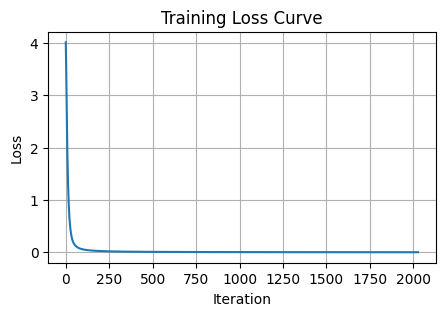

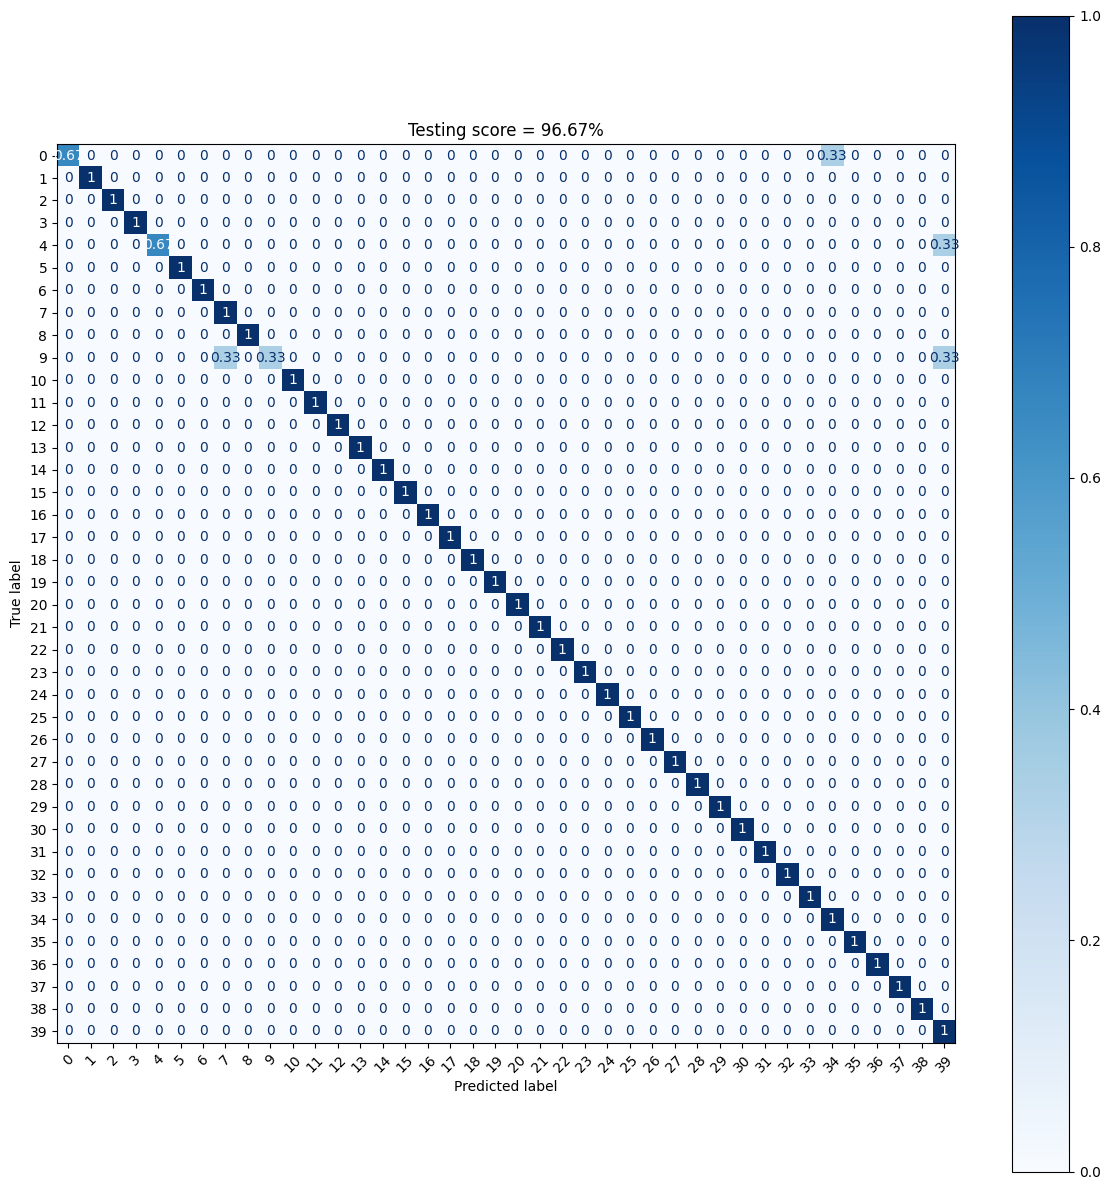

In [9]:
result = run_mlp_classifier(
    X_train_scaled, X_test_scaled, y_train, y_test,
    hidden_layers=(100,),
    activation='relu',
    solver='sgd',
    print_report=True,
    random_state=42
)

plot_mlp_loss_curve(result['model'])
plot_mlp_confusion_matrix(result['model'], X_test_scaled, y_test)

**測試準確率（Test Accuracy）**：96.67%，模型分類效果良好。

從損失曲線可觀察到以下現象：

- **初期損失較高**：初始 loss 約為 4，略高於 Adam 的初始值。
- **緩慢下降**：訓練初期損失下降速度較慢，相較於 Adam 極速下降，SGD 步伐較為保守。
- **收斂穩定但耗時較長**：大約需要數百次以上的迭代才能達到穩定的最低損失，且總訓練迭代達 2000 次。
- **曲線平滑穩定**：整體曲線仍然平滑無震盪，最終 loss 接近 0，顯示模型成功學習並收斂。

從混淆矩陣可以觀察到以下現象：

- 多數類別的預測集中於對角線，且對角線上的值幾乎皆為 **1.00**，表示被正確分類的比例高。
- 僅有少數幾筆樣本產生誤分類，且多數誤判值為 **0.33**。

## 2. 主成分資料

將原始標準化後的資料降維，保留 80% 的資料變異量（variance_ratio = 0.8）。

In [10]:
X_train_pca, X_test_pca, pca = apply_pca(X_train_scaled, X_test_scaled, variance_ratio=0.8)

### 2-1 多元羅吉斯回歸 

分別使用 `LogisticRegressionCV` 和 `GridSearchCV` 兩種方法對羅吉斯迴歸進行超參數搜尋與模型評估：

- 以下使用 `LogisticRegressionCV` 執行 5-fold 交叉驗證，設定 20 個對數尺度的 C 值，solver 為 `'lbfgs'`，得到以下結果：

In [ ]:
result = run_logistic_regression_cv(
    X_train_pca, X_test_pca, y_train, y_test,
    solver='lbfgs',
    Cs=np.logspace(-5, 5, 20),
    cv=5,
    tol=1e-6,
    max_iter=int(1e6),
    verbose=0,
    print_report=True
)

Logistic Regression with CV (solver = lbfgs)
Best C = [1.83298071 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071
 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071
 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071
 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071
 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071
 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071 1.83298071
 1.83298071 1.83298071 1.83298071 1.83298071]
Training Accuracy: 100.00%
Testing Accuracy : 96.67%
Elapsed time: 5.78 seconds


整體而言，訓練與測試準確率皆高、交叉驗證結果穩定，展現優異效能。

- 以下使用 `GridSearchCV` 執行 5-fold 交叉驗證，設定 C 值為 `0.1, 1, 10` ，solver 為 `'lbfgs', 'newton-cg', 'saga'`，得到以下結果：

In [ ]:
param_grid = {
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'C': [0.1, 1, 10]
}

result = run_logistic_gridcv(X_train_pca, y_train, param_grid=param_grid)

{'C': 1, 'solver': 'saga'}
0.919047619047619
LogisticRegression(C=1, max_iter=1000000, solver='saga', tol=1e-06)
Elapsed time: 312.62 seconds


交叉驗證下的平均準確率約為 91.90%，顯示所選參數組合在訓練階段表現良好。

### 2-2 支援向量機

#### 1. 使用線性核（`kernel='linear'`）的 SVC 模型進行分類

In [96]:
result = run_svm_classification(
    X_train_pca, X_test_pca, y_train, y_test,
    kernel='linear',
    use_linear_svc=False 
)

SVM Classification (SVC-linear)
Test Accuracy: 96.67%
Elapsed Time: 0.01 seconds


模型在測試集上表現良好，準確率達到 96.67%，顯示線性決策邊界對此資料集具有良好分類能力。

#### 2. 使用線性核（`kernel='rbf'`）的 SVC 模型進行分類

In [97]:
result = run_svm_classification(
    X_train_pca, X_test_pca, y_train, y_test,
    kernel='rbf',
    C=0.1,
    gamma=0.5,
    use_linear_svc=False
)

SVM Classification (SVC-rbf)
Test Accuracy: 85.83%
Elapsed Time: 0.01 seconds


手動調整多組 `C` 與 `gamma` 參數後，模型的最佳測試準確率為 **85.83%**，整體表現還是不佳。

#### 3. 使用線性核（`kernel='poly'`）的 SVC 模型進行分類
- degree=2

In [98]:
result = run_svm_classification(
    X_train_pca, X_test_pca, y_train, y_test,
    kernel='poly',
    degree=2,
    gamma='auto',
    use_linear_svc=False 
)

SVM Classification (SVC-poly)
Test Accuracy: 93.33%
Elapsed Time: 0.01 seconds


-  degree=3

In [103]:
result = run_svm_classification(
    X_train_pca, X_test_pca, y_train, y_test,
    kernel='poly',
    degree=3,
    gamma='auto',
    use_linear_svc=False 
)

SVM Classification (SVC-poly)
Test Accuracy: 90.00%
Elapsed Time: 0.01 seconds


使用多項式核函數（`kernel='poly'`）的 SVM 模型在本資料集上的表現相對有限，且隨著多項式次數增加，模型效能略有下降。當 **degree = 2** 時，測試準確率為 **93.33%**，提升至 **degree = 3** 時則下降至 **90.00%**，顯示高階多項式核並未帶來效能提升，反映資料本身對複雜非線性邊界的需求較低。

#### 4. 使用 `LinearSVC`

In [106]:
result = run_svm_classification(
    X_train_pca, X_test_pca, y_train, y_test,
    use_linear_svc=True  
)

SVM Classification (LinearSVC)
Test Accuracy: 93.33%
Elapsed Time: 0.06 seconds


使用 LinearSVC 進行分類，測試準確率為 **93.33%**，整體表現尚可。  

### 2-3 神經網路

#### 1. 使用一層隱藏層、130 個神經元的多層感知器（MLP）進行訓練，並採用 ReLU 作為啟用函數，Adam 作為優化器。

MLP Classifier Report
Test Accuracy: 95.00%
Elapsed Time: 0.96 seconds


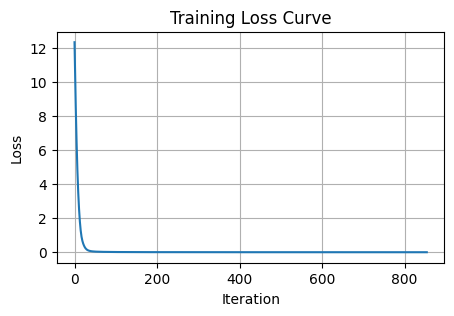

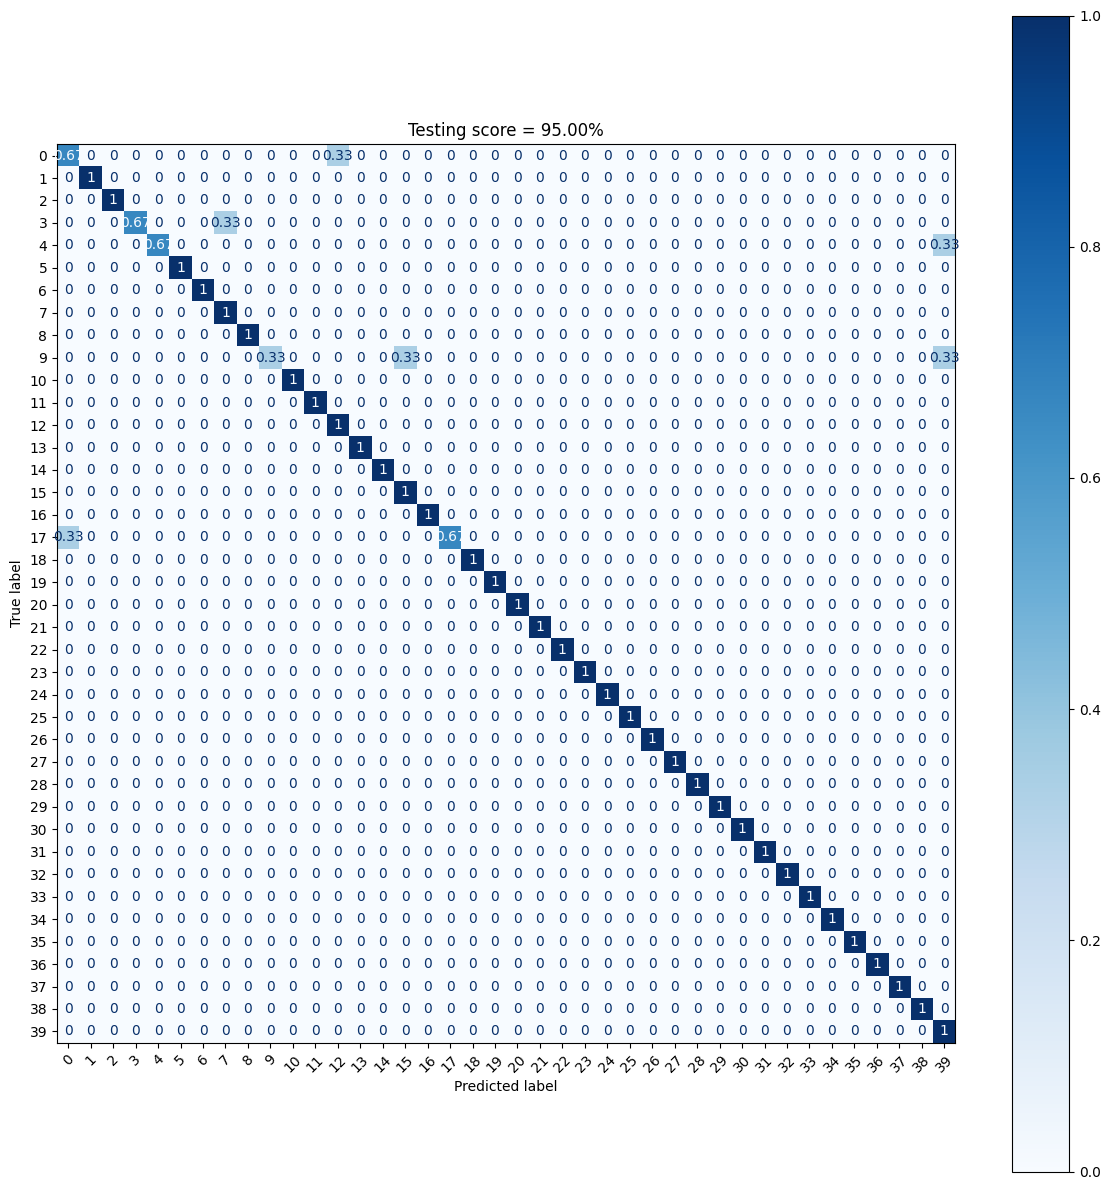

In [14]:
result = run_mlp_classifier(
    X_train_pca, X_test_pca, y_train, y_test,
    hidden_layers=(130,),
    activation='relu',
    solver='adam',
    print_report=True,
    random_state=42
)

plot_mlp_loss_curve(result['model'])
plot_mlp_confusion_matrix(result['model'], X_test_pca, y_test)

**測試準確率（Test Accuracy）**：95.00%，模型分類效果良好。

從損失曲線可觀察到以下現象：

- **快速下降**：訓練初期損失迅速下降，模型快速學習到關鍵特徵。
- **平穩收斂**：約在第 50 次迭代後，損失值趨於穩定並接近 0，顯示模型已成功收斂，未出現震盪現象。
- **曲線平滑**：整體曲線平滑穩定，代表訓練過程順利，Adam 優化器在此任務中表現良好。

從混淆矩陣可以觀察到以下現象：

- 多數類別的預測集中於對角線，且對角線上的值幾乎皆為 **1.00**，表示被正確分類的比例高。
- 僅有少數幾筆樣本產生誤分類，且多數誤判值為 **0.33**。

#### 2. 使用一層隱藏層、300 個神經元的多層感知器（MLP）進行訓練，並採用 ReLU 作為啟用函數，改採 sgd 作為優化器。

MLP Classifier Report
Test Accuracy: 95.00%
Elapsed Time: 3.17 seconds


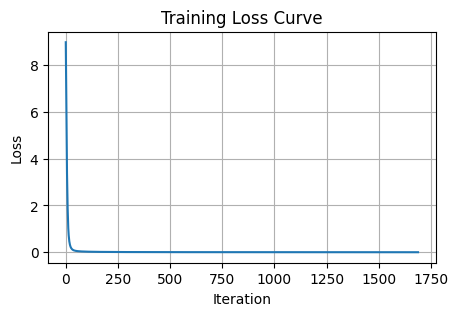

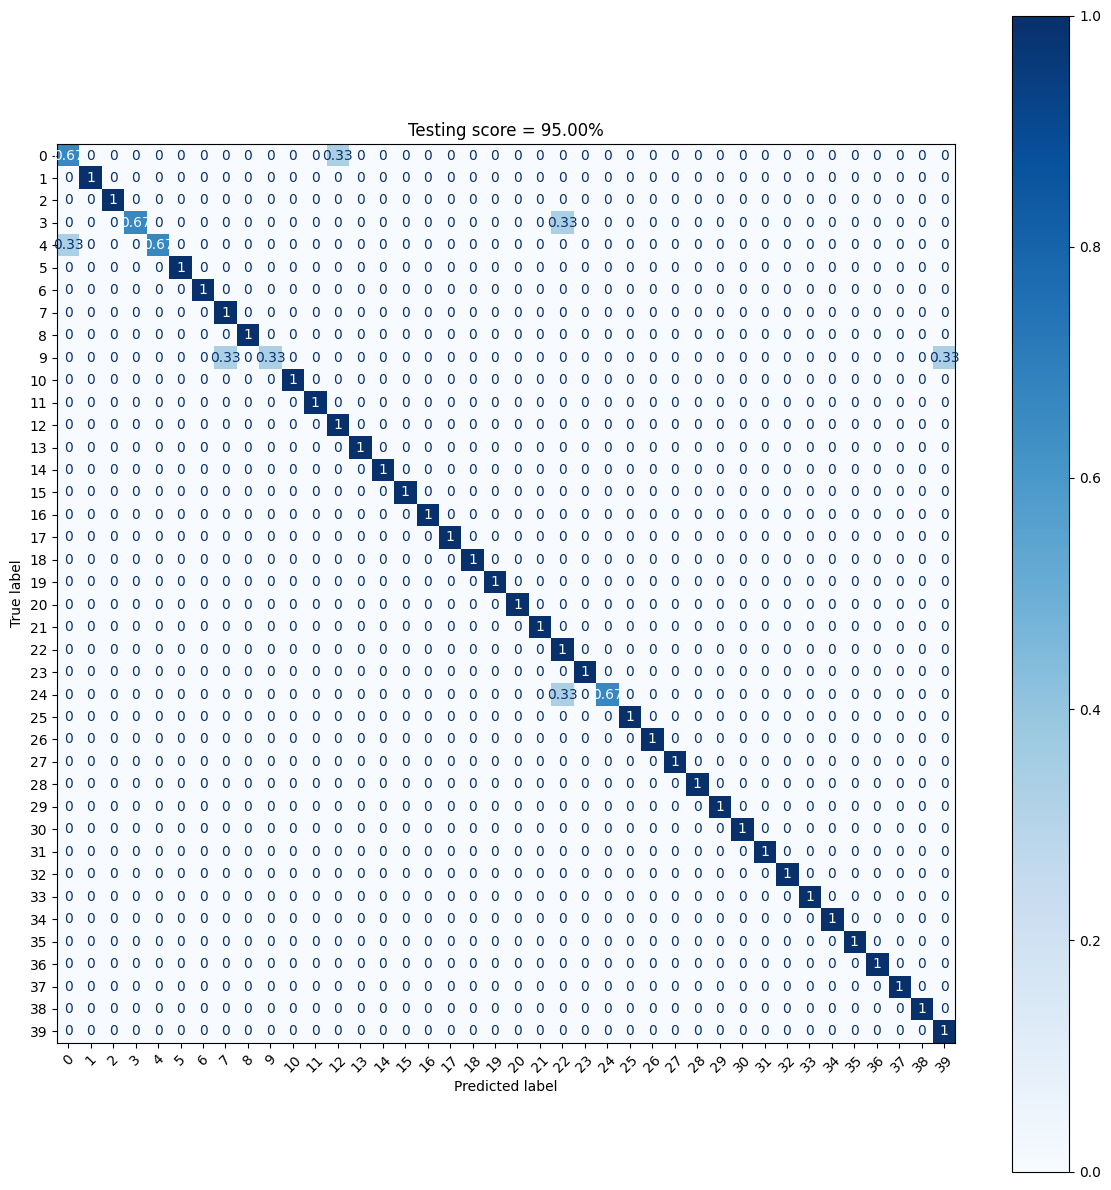

In [12]:
result = run_mlp_classifier(
    X_train_pca, X_test_pca, y_train, y_test,
    hidden_layers=(300,),
    activation='relu',
    solver='sgd',
    print_report=True,
    random_state=42
)

plot_mlp_loss_curve(result['model'])
plot_mlp_confusion_matrix(result['model'], X_test_pca, y_test)

**測試準確率（Test Accuracy）** 為 **95.00%**，顯示模型具備良好的分類能力。

從訓練損失曲線中可觀察到以下現象：

- **快速下降**：訓練初期損失迅速下降，模型快速學習到關鍵特徵。
- **平穩收斂**：約在第 60 次迭代後，損失值趨於穩定並接近 0，顯示模型已成功收斂，未出現震盪或過擬合現象。
- **收斂穩定但耗時較長**：模型大約經過數百次迭代後才逐漸趨於穩定，總迭代次數達 1750 次，顯示訓練耗時相對較長。
- **曲線平滑穩定**：整體損失曲線平滑無震盪，最終 loss 接近 0，表示模型已成功學習並完成有效收斂。

從混淆矩陣可以觀察到以下現象：

- 多數類別的預測集中於對角線，且對角線上的值幾乎皆為 **1.00**，表示被正確分類的比例高。
- 僅有少數幾筆樣本產生誤分類，且多數誤判值為 **0.33**。


### 整體測試準確率表現摘要

| 分類器             | 原始資料 (%) | 主成分資料 (%) | 差異說明                           |
|--------------------|---------------|------------------|------------------------------------|
| Logistic Regression | **97.50**     | **96.67**           | 主成分略降，仍保持穩定              |
| SVM-linear         | 96.67         | **96.67**            | 幾乎一致，PCA 影響極小              |
| SVM-rbf            | 90.00         | 85.83        | 準確率明顯下降，特徵壓縮影響非線性   |
| SVM-poly (deg=2)   | 78.33         | 93.33        | PCA 有助於決策邊界簡化與表現提升     |
| SVM-poly (deg=3)   | 63.33         | 90.00        | 明顯改善     |
| LinearSVC          | **98.33**     | 93.33            | 主成分略降但仍表現良好              |
| MLP-adam           | 96.67         | 95.00            | 表現穩定，略受 PCA 壓縮影響          |
| MLP-sgd            | 96.67         | 95.00            | 與 adam 類似，差異不大               |

---

### 討論與觀察重點

1. **最佳模型**為原始資料下的 **LinearSVC (98.33%)**，準確率最高，且 Logistic Regression 亦緊追在後。
2. **SVM-poly 核心受益最大**，降維後準確率從 63.33% / 78.33% 分別提升至 90.00% / 93.33%，PCA 有助改善非線性模型表現。
3. **SVM-rbf 下降幅度明顯**，顯示其對特徵完整性較為敏感。
4. **MLP（adam 與 sgd）表現穩定**，雖主成分資料下略降，但仍屬高準確率範圍（95%）。

---

### 結論建議

- 若追求最高準確率，推薦使用 **原始資料 + LinearSVC** 或 **Logistic Regression**。
- 若需降低維度（如資料龐大、訓練速度考量），則推薦使用 **主成分資料 + Logistic Regression /SVM-linear / MLP-adam  / MLP-sgd**。